# Boltzmann Distribution | Gas Inside a Box

This notebook is based on [this video](https://youtu.be/65kl4eE9ovI?si=h7XxmKXDbI19CBpc). Most of the content comes from [Mr. P Solver](https://www.youtube.com/@MrPSolver); here, I also add my insight on the analysis. 

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import scienceplots
from matplotlib import animation
from matplotlib.animation import PillowWriter 
from itertools import combinations

plt.style.use(['science', 'notebook'])

Consider a box containing a gas, with each collision exchanging energy. The initial position of these particles is random.

Begin with 400 particles, all containing randomized and normalized x and y positions. 

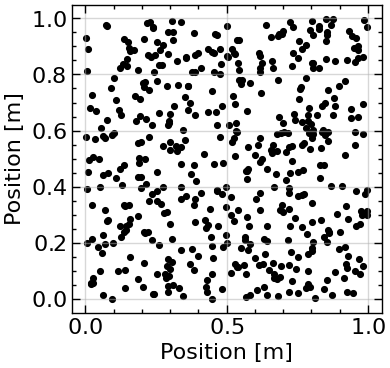

In [2]:
n_particles = 500
# x and y positions
np.random.seed(71)

r = np.random.random((2,n_particles)) # x, y positions
plt.figure(figsize=(4,4))
plt.scatter(r[0], r[1], c="k", s=17) # x vs y
plt.grid(alpha=0.5)
plt.xlabel("Position [m]"); plt.ylabel("Position [m]");

In [3]:
# discern the particles that start on the left and right
right_xbool = r[0] > 0.5; left_xbool = r[0] <= 0.5
# set ID of particles
id_particles = np.arange(n_particles)

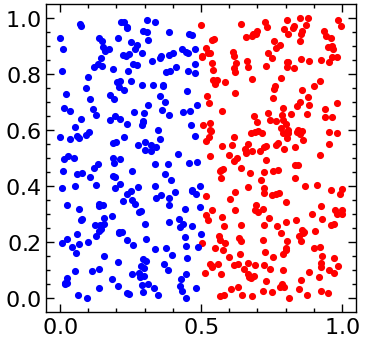

In [4]:
plt.figure(figsize=(4,4))
plt.scatter(r[0][right_xbool], r[1][right_xbool], c="r", s=17)
plt.scatter(r[0][left_xbool], r[1][left_xbool], c="b", s=17);
# The idea is to have the blue particles colliding the red particles and vice versa at 500 m/s

In [5]:
# Velocity Initialization
ivelocities = (500, 0) #m/s
v = np.zeros((2,n_particles))
v[0][right_xbool] = -ivelocities[0]; v[0][left_xbool] = ivelocities[0]
v[1][right_xbool] =  ivelocities[1]; v[1][left_xbool] = ivelocities[1]

## Distance between particles

It is important to keep track of the distance between **all pairs** so that when the distance becomes equal or less to the diameter of the particles, then they have the assignation of their new volicity and position. It is for this reason that all distance between pairs require their own ID. From combinatorics, the situation implies there will be $n(n-1)/2$ pairs, which can be obtained from the particles' IDs.

In [6]:
# combinations? ---> combinations(iterable, r-lenght)
list(combinations(id_particles[:10],5))[:3]

[(0, 1, 2, 3, 4), (0, 1, 2, 3, 5), (0, 1, 2, 3, 6)]

In [7]:
df = (pd.DataFrame([list(combinations(id_particles,2)), # id pairs
                    list(combinations(r[0],2)),         # xpos pairs
                    list(combinations(r[1],2))])        # ypos pairs
      .T.rename(columns={0:"IDs",1:"x_pairs", 2:"y_pairs"}))
df["delta_x"] = df["x_pairs"].apply(lambda _: np.abs(np.diff(_))[0])
df["delta_y"] = df["y_pairs"].apply(lambda _: np.abs(np.diff(_))[0])

The total distance is thus

$$
    d_{ij} = \sqrt{\Delta x_{ij}^2 + \Delta y_{ij}^2}
$$

In [8]:
df["d_ij"] = np.sqrt( df["delta_x"]*df["delta_x"] + df["delta_y"]*df["delta_y"] )
df.head()

,IDs,x_pairs,y_pairs,delta_x,delta_y,d_ij
0,"(0, 1)","(0.1855752748185393, 0.38659930304207)","(0.2943195451772188, 0.3573420339372043)",0.201024,0.063022,0.210672
1,"(0, 2)","(0.1855752748185393, 0.8318961986371698)","(0.2943195451772188, 0.42965502874837025)",0.646321,0.135335,0.660338
2,"(0, 3)","(0.1855752748185393, 0.19869744903988218)","(0.2943195451772188, 0.5581197436406221)",0.013122,0.263800,0.264126
3,"(0, 4)","(0.1855752748185393, 0.9165579658994917)","(0.2943195451772188, 0.07496142323611532)",0.730983,0.219358,0.763187
4,"(0, 5)","(0.1855752748185393, 0.7883107006384493)","(0.2943195451772188, 0.6550718429421359)",0.602735,0.360752,0.702447


Now, if the total distance is greater than the diamater of the balls, then the data must be updated. 

### Elastic Collisions

At each iteration, the total distance is checked such that it sets a new velocity when it takes a lower value than the diamater of the particle. For that, one considers the following elastic collision

$$
        \vec{v}^{new}_i = \vec{v}_i - \frac{(\vec{v}_i - \vec{v}_j)\cdot(\vec{r}_i - \vec{r}_j)}{\mid\vec{r}_i - \vec{r}_j\mid^2} (\vec{r}_i - \vec{r}_j),
$$

here, $i=\{1,2\}$ is the indexing of particles collinding.

In [9]:
radius = 0.06
# Colliding Particles
df[df.d_ij <= radius].head()

,IDs,x_pairs,y_pairs,delta_x,delta_y,d_ij
143,"(0, 144)","(0.1855752748185393, 0.15765577070186354)","(0.2943195451772188, 0.28603913956172)",0.027920,0.008280,0.029122
145,"(0, 146)","(0.1855752748185393, 0.1431376454253337)","(0.2943195451772188, 0.2607262650085401)",0.042438,0.033593,0.054124
205,"(0, 206)","(0.1855752748185393, 0.13919947255929865)","(0.2943195451772188, 0.3292464627470426)",0.046376,0.034927,0.058057
428,"(0, 429)","(0.1855752748185393, 0.15594194178571175)","(0.2943195451772188, 0.26543573727638514)",0.029633,0.028884,0.041381
439,"(0, 440)","(0.1855752748185393, 0.15361002715918548)","(0.2943195451772188, 0.33273343924721366)",0.031965,0.038414,0.049974


In [10]:
# Obtain indeces of colliding particles
colliding = df[df.d_ij <= 2*radius].copy()
particl_1_idx = colliding["IDs"].apply(lambda _: _[0])
particl_2_idx = colliding["IDs"].apply(lambda _: _[1])

# Obtain velocities (x,y) and positions (x,y) of colliding particles
v1 = v[:,particl_1_idx]; r1 = r[:, particl_1_idx] 
v2 = v[:,particl_2_idx]; r2 = r[:, particl_2_idx] 

Instead of separating the `v1` and `v2` arrays to become vectors and then perform the dot product, one takes the diagaonal of the matrix multiplication of `v1` and `v2` conserving the data structure they have now. The result, is a vector of dimension equal to the number of particles colliding. For instance

\begin{equation}
    \text{diag}\left(\:
    \begin{bmatrix}
        a_1 & b_2 \\
        a_1 & b_2 \\
        a_1 & b_2
    \end{bmatrix} 
    \cdot
    \begin{bmatrix}
        x_1 & x_2 & x_3\\
        y_1 & y_2 & y_3
    \end{bmatrix}\right)  = \left[ \:A\cdot X \:\:\:B \cdot Y \:\right].
\end{equation}

In [11]:
vi_new = lambda R1, V1, R2, V2: V1 - np.diag( (V1-V2).T @ (R1-R2) )*( R1-R2 )/np.sum((R1-R2)**2, axis=0)

v1_new = vi_new(r1,v1,r2,v2)
v2_new = vi_new(r2,v2,r1,v1)

# Converting to Fucntions for Animation

In [22]:
def get_initial_position(n_particles, seed=71):
    """
    Returns random (x,y) positions for a total of n_particles with ID. 
    """
    # x and y positions
    np.random.seed(seed)
    r = np.random.random((2,n_particles)) # x, y positions
    right_xbool = r[0] > 0.5; left_xbool = r[0] <= 0.5
    return r, right_xbool, left_xbool

def get_initial_velocities(n_particles, ivelocities):
    """
    Returns initital velocities for colliding particles: left vs right
    ivelocities (2D tuple of ints): (vx_0, vy_0) [m/s]
    """
    # discern the particles that start on the left and right
    r, right_xbool, left_xbool = get_initial_position(n_particles)
    # Velocity Initialization
    v = np.zeros((2,n_particles))
    v[0][right_xbool] = -ivelocities[0]; v[0][left_xbool] = ivelocities[0]
    v[1][right_xbool] =  ivelocities[1]; v[1][left_xbool] = ivelocities[1]
    return v
    
def get_idx_colliding_particles(radius, r):
    """
    This function assigns an unique ID to each particle and 
    determines distance between particles to obtain the colliding ones. 
    """
    df = (pd.DataFrame([
            list(combinations(np.arange( len(r[0]) ),2)), # id pairs
            list(combinations(r[0],2)),             # xpos pairs
            list(combinations(r[1],2))              # ypos pairs
            ])            
      .T.rename(columns={0:"IDs",1:"x_pairs", 2:"y_pairs"}))
    # get distance between particles
    df["delta_x"] = df["x_pairs"].apply(lambda _: np.abs(np.diff(_))[0])
    df["delta_y"] = df["y_pairs"].apply(lambda _: np.abs(np.diff(_))[0])
    df["d_ij"] = np.sqrt( df["delta_x"]*df["delta_x"] + df["delta_y"]*df["delta_y"] )
    # get colliding particles
    colliding = df[df["d_ij"] <= 2*radius].copy()
    particl_1_idx = colliding["IDs"].apply(lambda _: _[0])
    particl_2_idx = colliding["IDs"].apply(lambda _: _[1])
    return particl_1_idx, particl_2_idx

def update_velocities(r, v, particl_1_idx, particl_2_idx):
    """
    """
    # Obtain velocities (x,y) and positions (x,y) of colliding particles
    v1 = v[:,particl_1_idx]; r1 = r[:, particl_1_idx] 
    v2 = v[:,particl_2_idx]; r2 = r[:, particl_2_idx] 
    
    vi_new = (lambda R1, V1, R2, V2: 
                  V1 - np.diag( (V1-V2).T @ (R1-R2) )*( R1-R2 )/np.sum((R1-R2)**2, axis=0)
             )
    v1_new = vi_new(r1,v1,r2,v2)
    v2_new = vi_new(r2,v2,r1,v1)
    
    return v1_new, v2_new

In [23]:
def particles_motion(n_particles, radius, ivelocities, ts, dt):
    """
    Returns the updated position and velocity considering elastic collision.
    
    This function is used to create all the images needed for the simulation.
    """
    
    r = get_initial_position(n_particles)[0]
    v = get_initial_velocities(n_particles, ivelocities)
    
    # 3D vector: two-spatial, one time
    R = np.zeros((ts, r.shape[0], r.shape[1]))
    V = np.zeros((ts, v.shape[0], v.shape[1]))
    # Set Initial State
    R[0] = r.copy()
    V[0] = v.copy()
    for time in range(1,ts):
        particl_1_idx, particl_2_idx = get_idx_colliding_particles(radius, r)
        v[:,particl_1_idx], v[:,particl_2_idx] = update_velocities(r, v, particl_1_idx, particl_2_idx)

        # Confine particles inside a box
        v[0, r[0]>1] = -np.abs(v[0, r[0]>1])
        v[0, r[0]<0] =  np.abs(v[0, r[0]<0])
        v[1, r[1]>1] = -np.abs(v[1, r[1]>1])
        v[1, r[1]<0] =  np.abs(v[1, r[1]<0])
        
        r = r + v*dt
        R[time] = r.copy()
        V[time] = v.copy()
        
    return R, V

## Implementing the functions: test with 16 particles

In [24]:
n_particles = 16
radius = 0.06          # [m]
ivelocities = (500, 0) # [m/s]

_, right_xbool, left_xbool = get_initial_position(n_particles)

In [25]:
R, V = particles_motion(n_particles, radius, ivelocities, ts=1000, dt=0.000005)

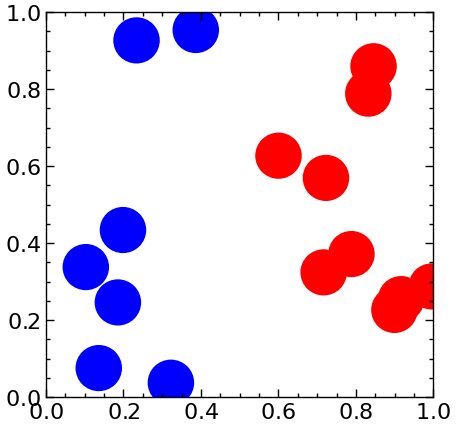

In [26]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

def animate(i):
    ax.clear()
    xred, yred   = R[i][0][right_xbool],  R[i][1][right_xbool]
    xblue, yblue = R[i][0][left_xbool], R[i][1][left_xbool]
    circles_red  = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xred,yred)]
    circles_blue = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xblue,yblue)]
    cred  = matplotlib.collections.PatchCollection(circles_red, facecolors='red')
    cblue = matplotlib.collections.PatchCollection(circles_blue, facecolors='blue')
    ax.add_collection(cred)
    ax.add_collection(cblue)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50)
ani.save('test.gif', writer='pillow', fps=30,dpi=100)

## Implementing the functions: 500 particles

In [29]:
n_particles = 500
radius = 0.0015        # [m]
ivelocities = (500, 0) # [m/s]

_, right_xbool, left_xbool = get_initial_position(n_particles)
R, V = particles_motion(n_particles, radius, ivelocities, ts=1000, dt=0.000005)

# Running: 22:42 -- 23:30

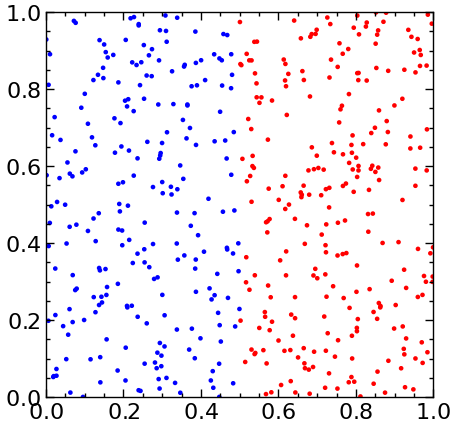

In [31]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

def animate(i):
    ax.clear()
    xred, yred   = R[i][0][right_xbool],  R[i][1][right_xbool]
    xblue, yblue = R[i][0][left_xbool], R[i][1][left_xbool]
    circles_red  = [plt.Circle((xi, yi), radius=4*radius, linewidth=0) for xi,yi in zip(xred,yred)]
    circles_blue = [plt.Circle((xi, yi), radius=4*radius, linewidth=0) for xi,yi in zip(xblue,yblue)]
    cred  = matplotlib.collections.PatchCollection(circles_red, facecolors='red')
    cblue = matplotlib.collections.PatchCollection(circles_blue, facecolors='blue')
    ax.add_collection(cred)
    ax.add_collection(cblue)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50)
ani.save('collision_500_bigrad_particles.gif', writer='pillow', fps=30,dpi=100)